# Econ: Overlapping Generations | Problemset

Alberto Quaini

### Import libraries

In [203]:
import numpy as np
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt

### Parameters

In [8]:
beta = 0.96**20               # 20-year discount factor
delta = 1 - (1 - 0.05)**20    # 20-year capital depreciation rate
sigma = 3                     # risk-aversion parameter
A = 1                         # productivity scale parameter
alpha = 0.35                  # capital share of income

## Exercise 2.1

Define 'feasible' function

In [63]:
def feasible(f_params, bvec_guess):
    """
    -------
    inputs: 
    -------
    f_params, tuple = (nvec, A, alpha, delta).
        nvec, array(3,1): labour supply of various generations.
        A, scalar: productivity scale parameter.
        alpha, scalar: capital share of income.
        delta, scalar: 20-year capital depreciation rate.
    bvec_guess, array(2,1): guess of steady-state savings vector.
    --------
    returns:
    --------
    b_cnstr, boolean(2,1): ith entry True if ith bvec_guess 
                           is responsible for any nonnegativity
                           constraint violation in c_cnstr.
    c_cnstr, boolean(3,1): True if c_s <= 0, s=1,2,3.
    K_cnstr, boolean(1,1): True if K <= 0.
    """
    
    K_cnstr = bvec_guess.sum() <= 0
    b_cnstr = np.array([False, False])
    c_cnstr = np.array([False, False, False])
    c = np.zeros((3, 1))
    
    K = bvec_guess.sum()
    L = f_param[0].sum()
    r = f_param[2] * f_param[1] * (L / K)**(1 - f_param[2]) - f_param[3]
    w = (1 - f_param[2]) * f_param[1] * (K / L)**f_param[2]
    c[0] = w * f_param[0][0] - bvec_guess[0]
    c[1] = w * f_param[0][1] + (1 + r) * bvec_guess[1]
    c[2] = w * f_param[0][2] + (1 + r) * bvec_guess[1]
    
    c_cnstr = c <= 0
    if c_cnstr[0]:
        b_cnstr[0] = True
    if c_cnstr[1]:
        b_cnstr[0] = True
        b_cnstr[1] = True
    if c_cnstr[2]:
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

In [64]:
nvec = np.array([1, 1, 0.2])
f_param = (nvec, A, alpha, delta)
bvec_guess = np.array([1, 1.2])

print(feasible(f_params, bvec_guess))
bvec_guess = np.array([0.06, -0.001])
print(feasible(f_params, bvec_guess))
bvec_guess = np.array([0.1, 0.1])
print(feasible(f_params, bvec_guess))


(array([ True, False]), array([[ True],
       [False],
       [False]]), False)
(array([False, False]), array([[False],
       [False],
       [False]]), False)
(array([False, False]), array([[False],
       [False],
       [False]]), False)


## Exercise 2.2

In [127]:
def u_prime(c, params):
    """ Compute the derivative of utility function
    """
    
    if c >= 1e-6:
        return c**(-params[1])
    else:
        return 1e6**3

In [128]:
def get_r(b_ss, params):
    """ Compute the steady-state interest rate
    """
    
    arg = params[2].sum() / b_ss.sum()
    return params[5] * params[4] * arg**(1 - params[5]) - params[6]

In [129]:
def get_w(b_ss, params):
    """ Comute the steady-state wage 
    """
    
    arg = b_ss.sum() / params[2].sum()
    return (1 - params[5]) * params[4] * arg**params[5]

In [166]:
def get_EulErr(b_ss, params):
    """ Compute the steady-state Euler equations errors
    """
    
    r_ss = get_r(b_ss, params)
    w_ss = get_w(b_ss, params)
    
    c1_ss = params[2][0] * w_ss - b_ss[0]
    c2_ss = params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c3_ss = params[2][2] * w_ss + (1 + r_ss) * b_ss[1]
    
    eulerr1_ss = u_prime(c1_ss, params) - params[0] * (1 + r_ss) * u_prime(c2_ss, params)
    eulerr2_ss = u_prime(c2_ss, params) - params[0] * (1 + r_ss) * u_prime(c3_ss, params)
    
    return np.array([eulerr1_ss, eulerr2_ss])
    

In [219]:
def plot_c_ss(c_ss):
    x = np.arange(3)
    plt.bar(x, c_ss)
    plt.xticks(x, ('C 1', 'C 2', 'C 3'))
    plt.title('Steady-state consumption')
    plt.show()

In [220]:
def plot_b_ss(b_ss):
    x = np.arange(2)
    plt.bar(x, b_ss)
    plt.xticks(x, ('b 2', 'b 3'))
    plt.title('Steady-state savings')
    plt.show()

In [221]:
def get_ss(params, bvec_guess, ss_graphs = False):
    """
    ------
    inputs
    ------
    params, tuple: ((beta, sigma, nvec, L, A, alpha, delta, SS tol)).
    bvec_guess, array(2,1): guess of steady-state savings vector.
    ss_graphs, boolean: generates a figure of the steady-state 
                        distribution of consump- tion and savings 
                        if it is set to True.
    --------
    outputs:
    --------
    ss_output, dict: dictionary with the steady-state solution values 
                     for the following endogenous objects.
    """
    start_time = time.clock()
    
    result = opt.root(get_EulErr, bvec_guess, args = params, tol = params[7])
    b_ss = np.round(result.x, 5)
    r_ss = np.round(get_r(b_ss, params), 5)
    w_ss = np.round(get_w(b_ss, params), 5)
    
    c1_ss = np.round(params[2][0] * w_ss - b_ss[0], 5)
    c2_ss = np.round(params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1], 5)
    c3_ss = np.round(params[2][2] * w_ss + (1 + r_ss) * b_ss[1], 5)
    
    c_ss = np.round(np.array([c1_ss, c2_ss, c3_ss]), 5)
    K_ss = np.round(b_ss.sum(), 5)
    L_ss = np.round(params[2].sum(), 5)
    Y_ss = np.round(params[4] * K_ss**params[5] * L_ss**(1 - params[5]), 5)
    C_ss = np.round(Y_ss - params[6] * K_ss, 5)
    EulErr_ss = result.fun
    RCerr_ss = Y_ss - C_ss - params[6] * K_ss
    
    ss_time = np.round(time.clock() - start_time, 5)
    
    if ss_graphs:
        plot_c_ss(c_ss)
        plot_b_ss(b_ss)
    
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    return ss_output


In [222]:
bvec_guess = np.array([.1, .1])
ss_tol = 1e-6
L = nvec.sum()
params = [beta, sigma, nvec, L, A, alpha, delta, ss_tol]

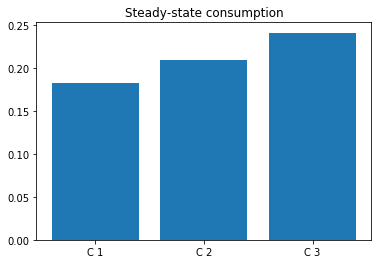

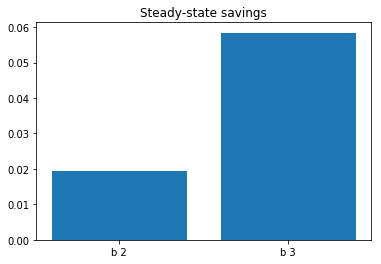

{'C_ss': 0.63289,
 'EulErr_ss': array([ 4.58641125e-10, -8.88931595e-10]),
 'K_ss': 0.07772,
 'RCerr_ss': 1.525889591895424e-06,
 'Y_ss': 0.68275,
 'b_ss': array([0.01931, 0.05841]),
 'c_ss': array([0.18241, 0.2096 , 0.24087]),
 'r_ss': 2.43314,
 'ss_time': 0.00076,
 'w_ss': 0.20172}

In [223]:
get_ss(params, bvec_guess, ss_graphs = True)

In [224]:
beta = 0.55               # 20-year discount factor
params = [beta, sigma, nvec, L, A, alpha, delta, ss_tol]

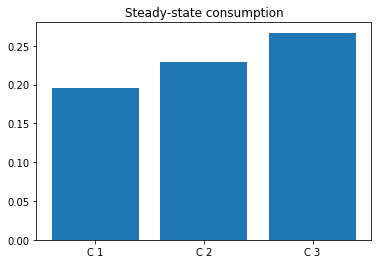

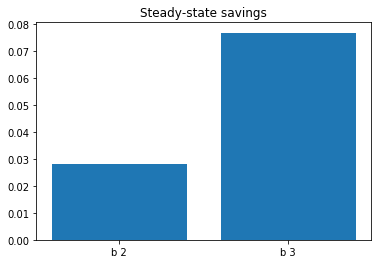

{'C_ss': 0.6913,
 'EulErr_ss': array([-6.82537689e-08, -2.50616949e-08]),
 'K_ss': 0.10505,
 'RCerr_ss': -1.0538509827295872e-06,
 'Y_ss': 0.75869,
 'b_ss': array([0.02818, 0.07687]),
 'c_ss': array([0.19598, 0.22862, 0.2667 ]),
 'r_ss': 1.88624,
 'ss_time': 0.00063,
 'w_ss': 0.22416}

In [225]:
get_ss(params, bvec_guess, ss_graphs = True)